**Requires**
* `'lincs_full_smiles_sciplex_genes.h5ad'`
* `'trapnell_cpa.h5ad'`

**Output**
* `'lincs_complete.h5ad'`

## Imports

In [1]:
import os 
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import sfaira

from compert.paths import DATA_DIR, PROJECT_DIR
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = False
matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
os.getcwd()
pd.set_option('display.max_columns', 100)
sc.set_figure_params(dpi=80, frameon=False)
sc.logging.print_header()
sns.set_context("poster")

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 pynndescent==0.5.5


In [2]:
%load_ext autoreload
%autoreload 2

## Load data

In [3]:
adata_lincs = sc.read(PROJECT_DIR/'datasets'/'lincs_full_smiles_sciplex_genes.h5ad')

In [4]:
adata_sciplex = sc.read(PROJECT_DIR/'datasets'/'trapnell_cpa.h5ad')

In [5]:
adata_lincs

AnnData object with n_obs × n_vars = 840677 × 977
    obs: 'cell_id', 'det_plate', 'det_well', 'lincs_phase', 'pert_dose', 'pert_dose_unit', 'pert_id', 'pert_iname', 'pert_mfc_id', 'pert_time', 'pert_time_unit', 'pert_type', 'rna_plate', 'rna_well', 'condition', 'cell_type', 'dose_val', 'cov_drug_dose_name', 'control', 'split', 'canonical_smiles', 'split1', 'random_split'
    var: 'pr_gene_title', 'pr_is_lm', 'pr_is_bing', 'gene_id', 'in_sciplex'
    uns: 'cydata_pull', 'rank_genes_groups_cov'

In [6]:
adata_sciplex

AnnData object with n_obs × n_vars = 581777 × 2000
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'batch', 'n_counts', 'dose_val', 'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'control', 'split_ho_pathway', 'split_tyrosine_ood', 'split_epigenetic_ood', 'split_cellcycle_ood', 'SMILES'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'gene_id', 'in_lincs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'all_DEGs', 'hvg', 'lincs_DEGs'

## Create the `drugs_df` that includes the trapnell ood drugs

In [8]:
def tanimoto_score(input_smiles, target_smiles):
    input_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(input_smiles))
    target_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(target_smiles))
    return DataStructs.TanimotoSimilarity(input_fp, target_fp)

In [9]:
ood_drugs = ["SNS-314", "Flavopiridol", "Roscovitine"]
ood_drugs.extend(["Azacitidine", "Pracinostat", "Trichostatin", "Quisinostat", "Tazemetostat"])
ood_drugs.extend(["Cediranib", "Crizotinib", "Motesanib", "BMS-754807", "Nintedanib"])

In [10]:
drugs_df = adata_sciplex.obs.loc[adata_sciplex.obs.condition.isin(ood_drugs), ['condition','SMILES','pathway_level_1']]
drugs_df = drugs_df.drop_duplicates()

In [12]:
drugs_df

,condition,SMILES,pathway_level_1
index,,,
A01_E09_RT_BC_102_Lig_BC_35-0-0-0,SNS-314,CS(=O)(=O)O.O=C(Nc1cccc(Cl)c1)Nc1ncc(CCNc2ncnc...,Cell cycle regulation
A01_E09_RT_BC_105_Lig_BC_132-0-0-0,Nintedanib,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,Tyrosine kinase signaling
A01_E09_RT_BC_108_Lig_BC_256-0-0-0,Quisinostat,Cl.Cl.Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2c...,Epigenetic regulation
A01_E09_RT_BC_115_Lig_BC_90-0-0-0,Crizotinib,CC(Oc1cc(-c2cnn(C3CCNCC3)c2)cnc1N)c1c(Cl)ccc(F...,Tyrosine kinase signaling
A01_E09_RT_BC_120_Lig_BC_323-0-0-0,Roscovitine,CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1,Cell cycle regulation
A01_E09_RT_BC_129_Lig_BC_15-0-0-0,Flavopiridol,CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C...,Cell cycle regulation
A01_E09_RT_BC_134_Lig_BC_93-0-0-0,Azacitidine,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,Epigenetic regulation
A01_E09_RT_BC_167_Lig_BC_196-0-0-0,Tazemetostat,CCN(c1cc(-c2ccc(CN3CCOCC3)cc2)cc(C(=O)NCc2c(C)...,Epigenetic regulation
A01_E09_RT_BC_170_Lig_BC_90-0-0-0,BMS-754807,CC1(C(=O)Nc2ccc(F)nc2)CCCN1c1nc(Nc2cc(C3CC3)[n...,Tyrosine kinase signaling


## Create the `lincs_df` that contains all drugs from the lincs dataset

In [29]:
lincs_df = adata_lincs.obs.loc[:, ['condition', 'canonical_smiles']].drop_duplicates()
lincs_df.canonical_smiles

## Compare the tanimoto similarity between the ood drugs and all lincs drugs
And add them to the `lincs_df` as `tanimoto_sim_{condition}` columns

In [46]:
from tqdm.notebook import tqdm

smiles_trapnell = []
smiles_lincs = []
for i, (drug, smiles, pathway) in tqdm(drugs_df.iterrows()):
    tanimoto_sim_col = f"tanimoto_sim_{drug}"
    lincs_df[tanimoto_sim_col] = lincs_df.canonical_smiles.apply(lambda lincs_smiles: tanimoto_score(lincs_smiles, smiles))
    most_similar = lincs_df.sort_values(tanimoto_sim_col, ascending=False).head(2)
#     print(most_similar)
    smiles_trapnell.append(smiles)
    smiles_lincs.append(most_similar)
#     print(drug, any(lincs_df.canonical_smiles.isin([smiles])), most_similar[tanimoto_sim_col], most_similar["drug"])
#     print(lincs_df.sort_values(tanimoto_sim_col, ascending=False).head(5)[["drug", tanimoto_sim_col]])

0it [00:00, ?it/s]

## Add the top two most siilar drugs to the ood set in lincs

In [115]:
ood_idx = []
n_ood = 2

for condition in ood_drugs: 
    idx = lincs_df[f'tanimoto_sim_{condition}'].sort_values(ascending=False)[:4].index.tolist()
    ood_idx.extend(idx[:n_ood])    
    
lincs_df.loc[ood_idx, ['condition'] + [c for c in lincs_df.columns if 'tanimoto_sim' in c]]

,condition,tanimoto_sim_SNS-314,tanimoto_sim_Nintedanib,tanimoto_sim_Quisinostat,tanimoto_sim_Crizotinib,tanimoto_sim_Roscovitine,tanimoto_sim_Flavopiridol,tanimoto_sim_Azacitidine,tanimoto_sim_Tazemetostat,tanimoto_sim_BMS-754807,tanimoto_sim_Pracinostat,tanimoto_sim_Trichostatin,tanimoto_sim_Motesanib,tanimoto_sim_Cediranib
index,,,,,,,,,,,,,,
CPC013_A375_6H_X1_B4_DUO52HI53LO:C13-1,SNS-314,0.990891,0.370089,0.306063,0.365422,0.363955,0.378109,0.271651,0.395833,0.413569,0.299928,0.226252,0.348463,0.341075
REP.A007_A375_24H_X1_B22:I07-2,GDC-0941,0.505937,0.455934,0.376963,0.451632,0.389674,0.457686,0.319922,0.470412,0.503326,0.360077,0.213986,0.378914,0.424132
REP.A026_A375_24H_X1_B25:B21-2,alvocidib,0.381130,0.426046,0.335509,0.431277,0.389029,1.000000,0.300856,0.425519,0.501131,0.353250,0.211552,0.347017,0.416408
CPC003_HA1E_6H_X2_B3_DUO52HI53LO:K04-1,vitexin,0.413428,0.466930,0.349332,0.454650,0.401296,0.719014,0.342697,0.468376,0.540850,0.351057,0.216678,0.358209,0.430070
REP.A011_A375_24H_X1_B24:O07-2,roscovitine,0.365479,0.362714,0.331583,0.385953,1.000000,0.389029,0.288738,0.366902,0.442494,0.322009,0.210843,0.332119,0.340454
CPC002_HA1E_6H_X1_B3_DUO52HI53LO:O16-1,BRD-K71726959,0.356436,0.357097,0.318423,0.367361,0.962733,0.374128,0.282859,0.349871,0.421563,0.319789,0.207930,0.325203,0.329737
LJP008_ASC_24H_X1.A2_B22:G19-2,azacitidine,0.273599,0.283044,0.240385,0.286611,0.288738,0.300856,1.000000,0.283884,0.322699,0.243437,0.178821,0.250585,0.262225
CPD003_MCF7_6H_X1_B6_DUO52HI53LO:M13-1,azacitidine,0.273599,0.283044,0.240385,0.286611,0.288738,0.300856,1.000000,0.283884,0.322699,0.243437,0.178821,0.250585,0.262225
CPC008_A375_6H_X1_B3_DUO52HI53LO:D11-1,BRD-K05979026,0.287172,0.325000,0.325815,0.311978,0.325228,0.332672,0.245484,0.331734,0.345800,0.573674,0.192759,0.258436,0.333333


### Compare the ood_drugs with the second most similar drug in lincs

In [116]:
smiles_lincs = lincs_df.loc[ood_idx[1::2], 'canonical_smiles'].values.tolist()

In [117]:
smiles_sciplex = []
for ood_drug in ood_drugs: 
    smiles_sciplex.extend(drugs_df.loc[drugs_df.condition==ood_drug, 'SMILES'].values.tolist())

0.5059366754617414


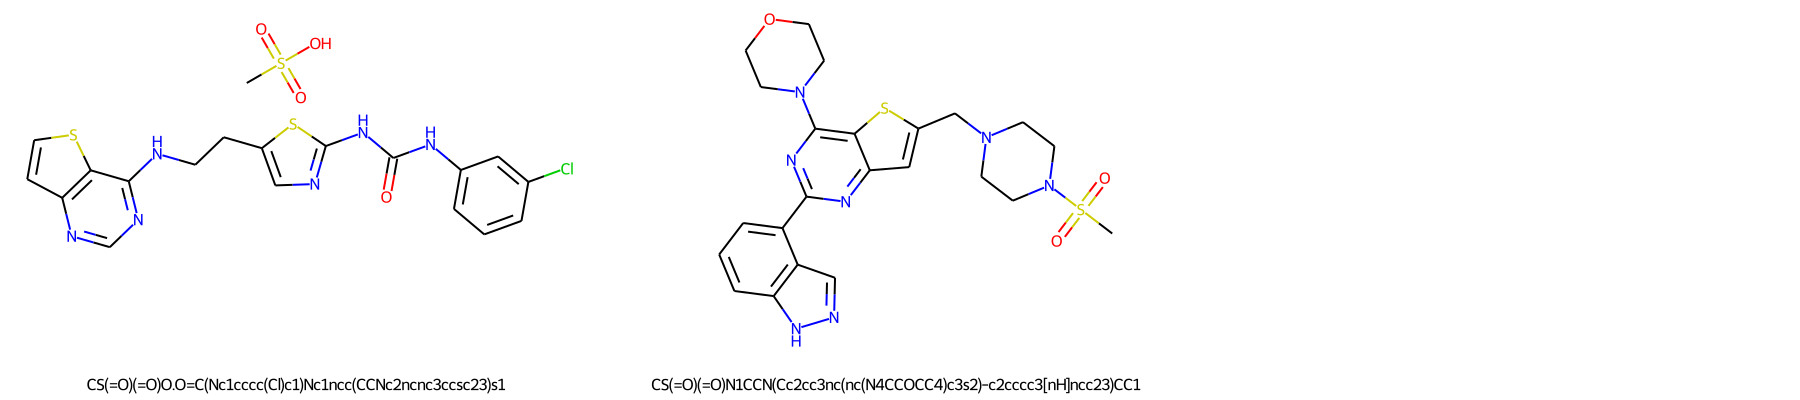

0.719013627514601


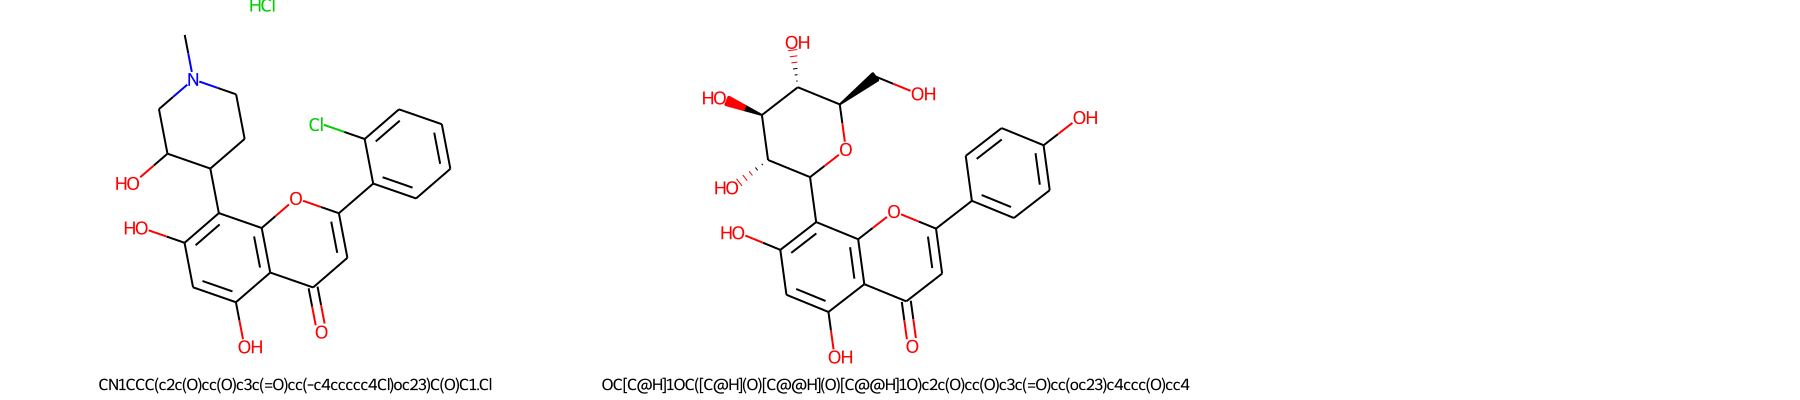

0.9627329192546584


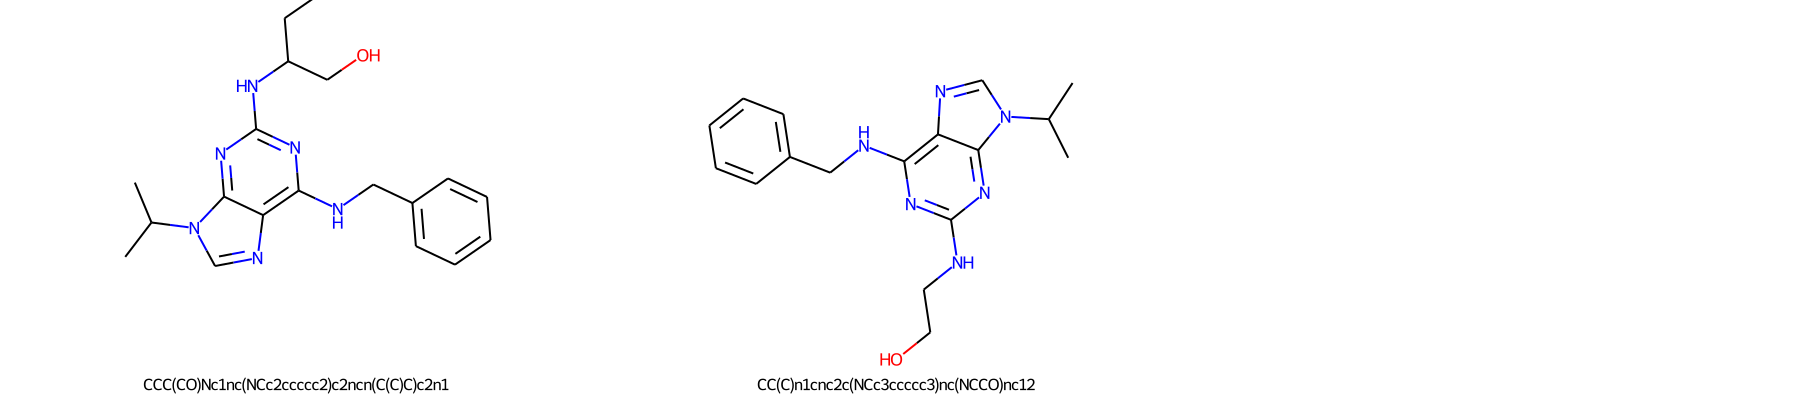

1.0


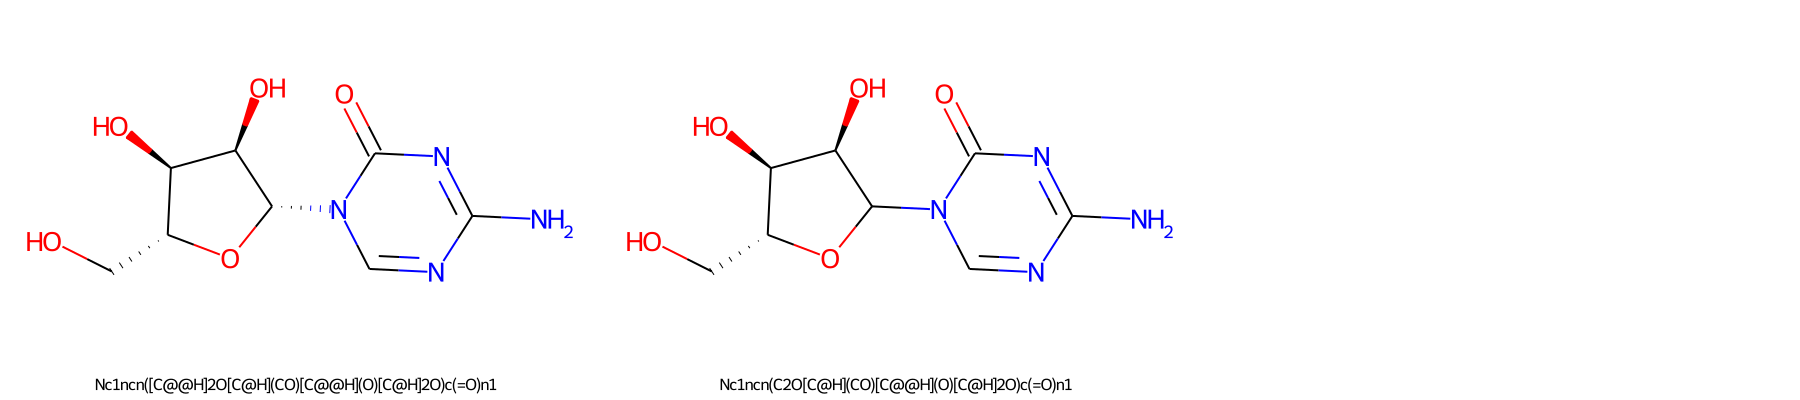

0.5318949343339587


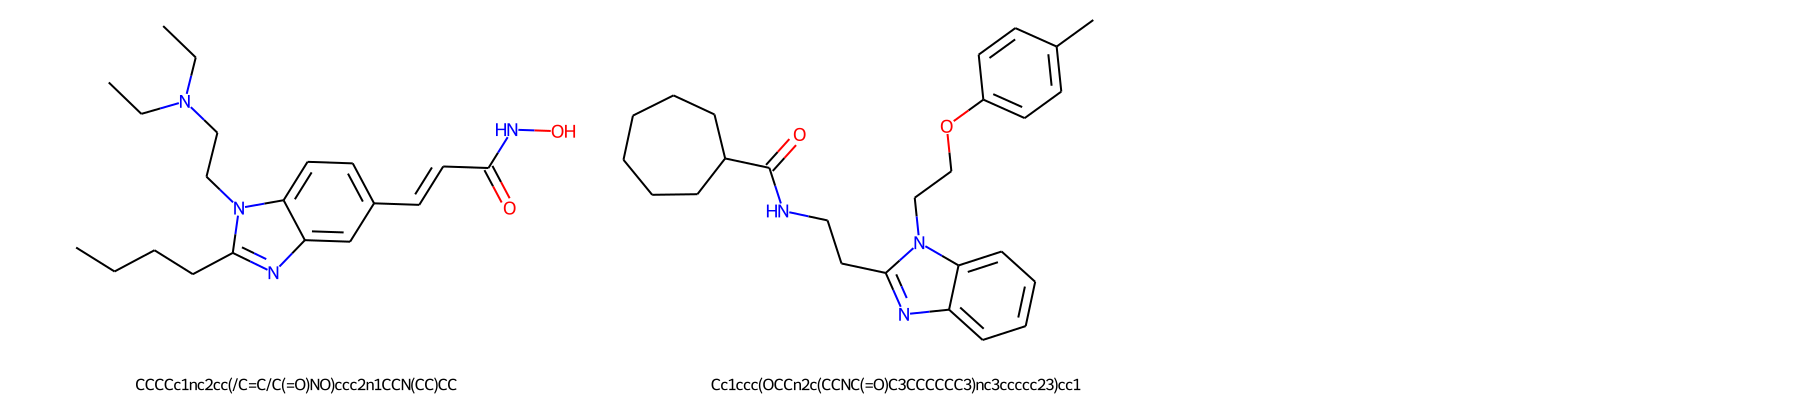

1.0


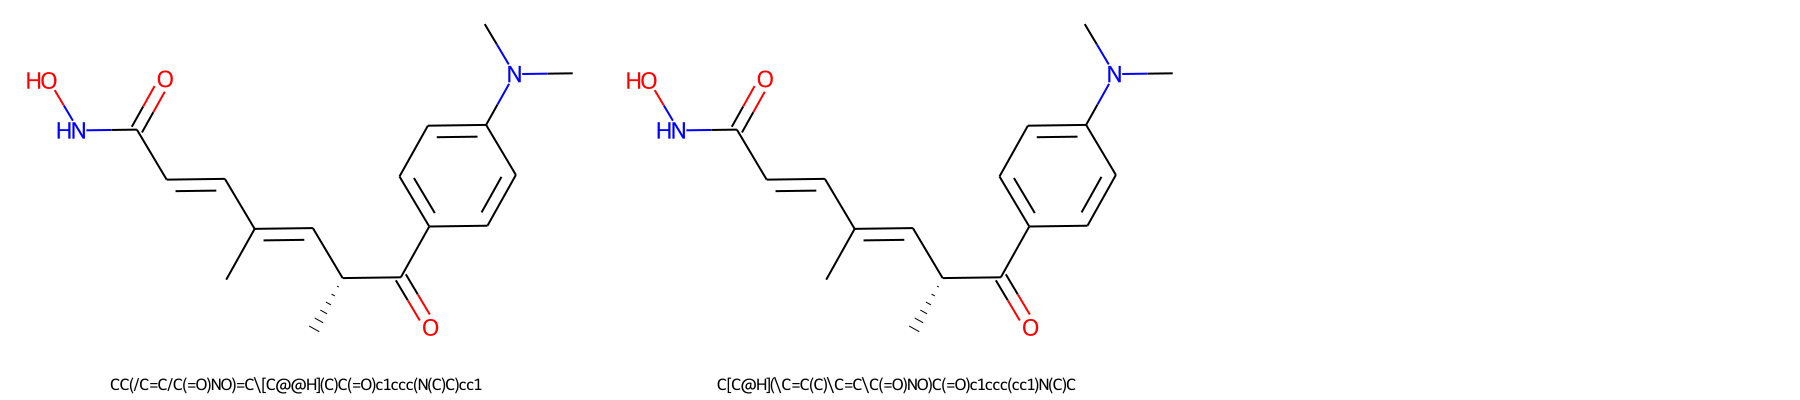

0.5194174757281553


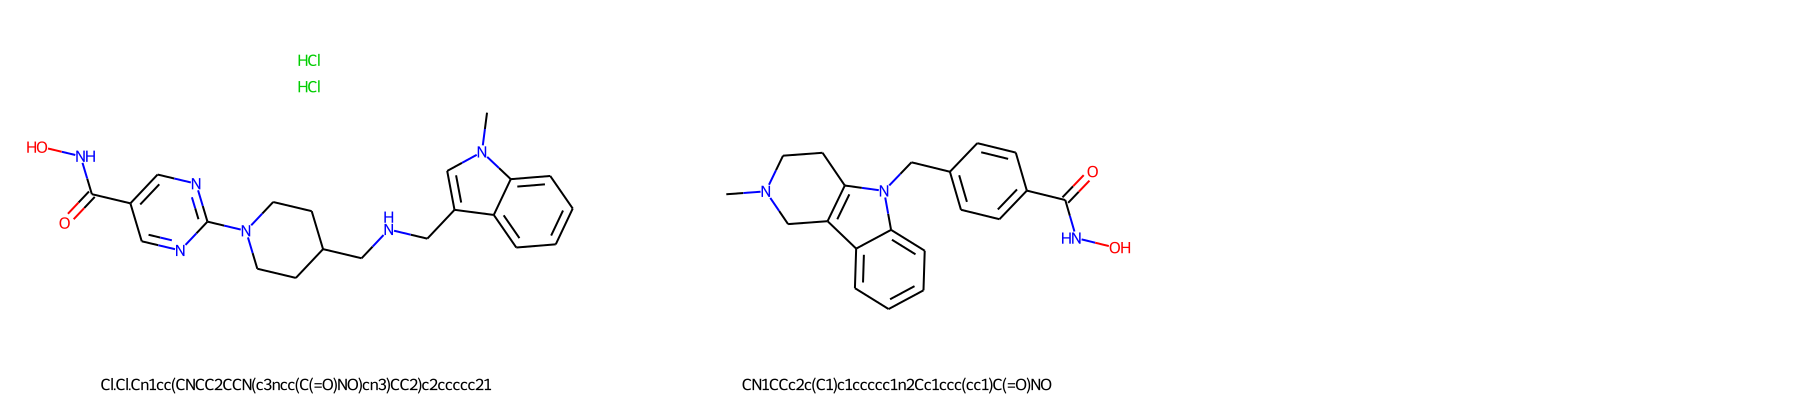

0.5682841420710355


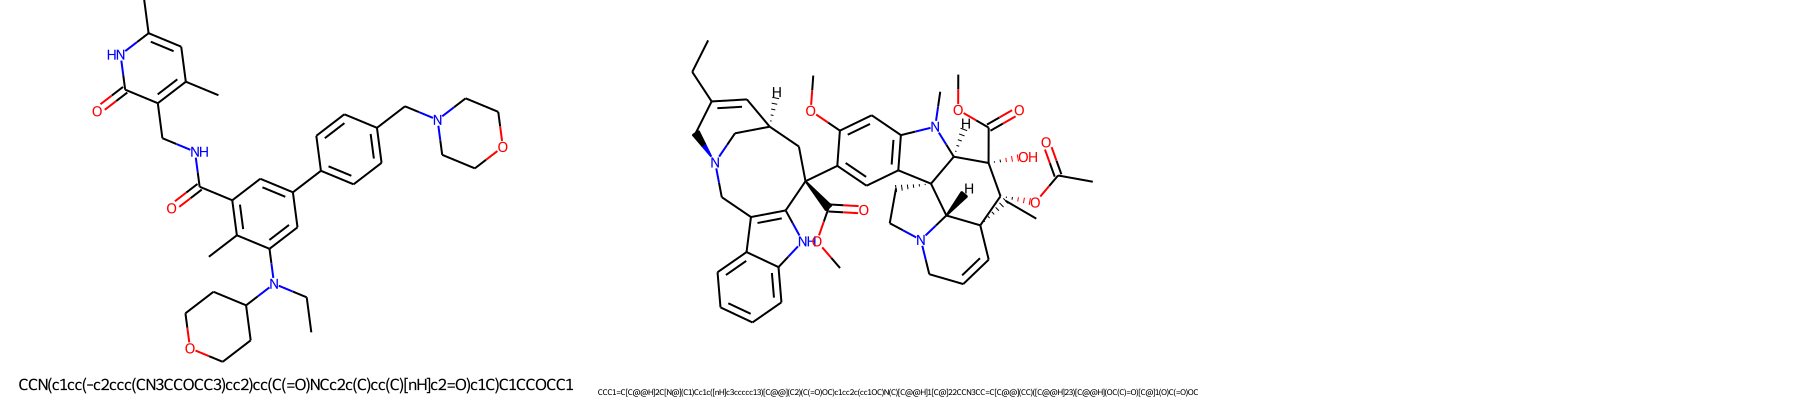

0.6227208976157083


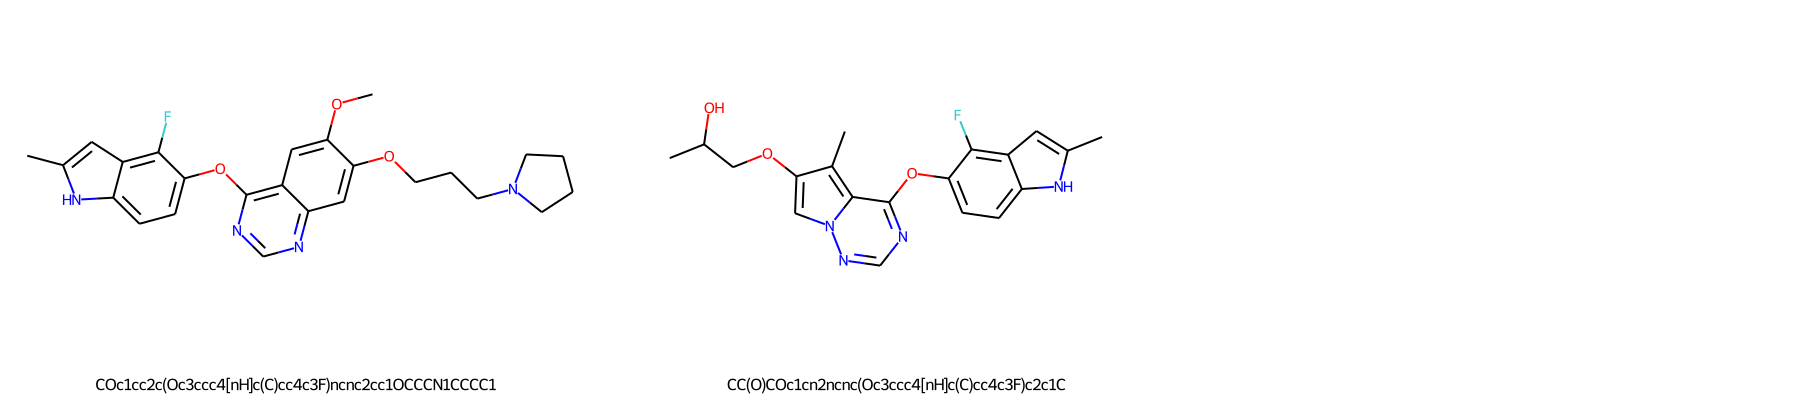

0.5341922695738355


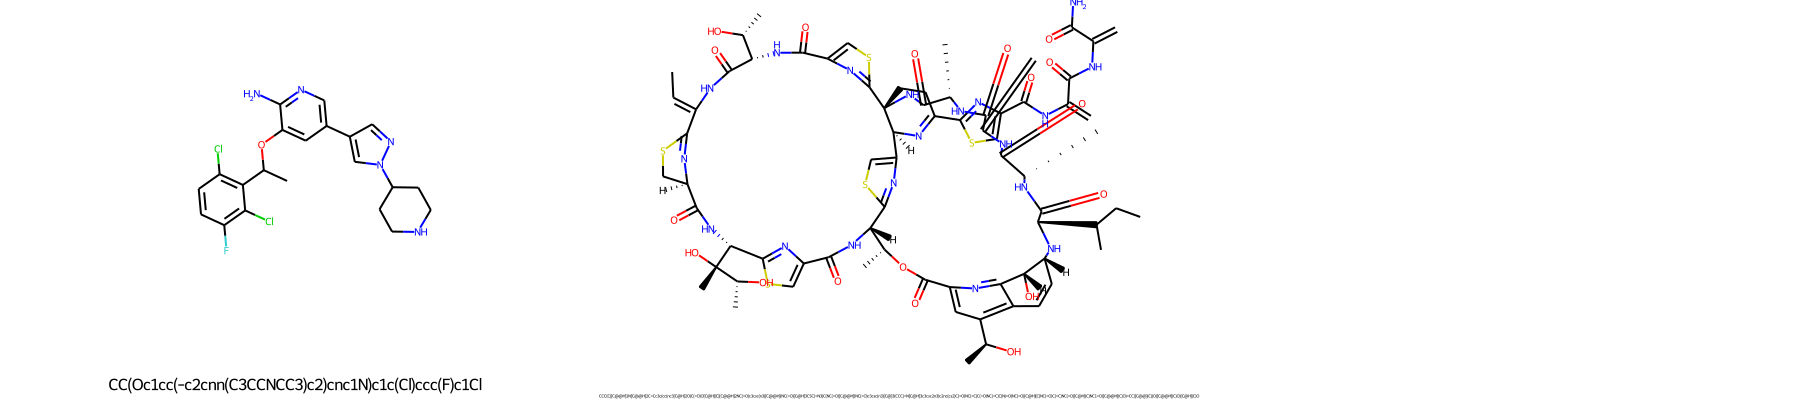

0.49525893508388036


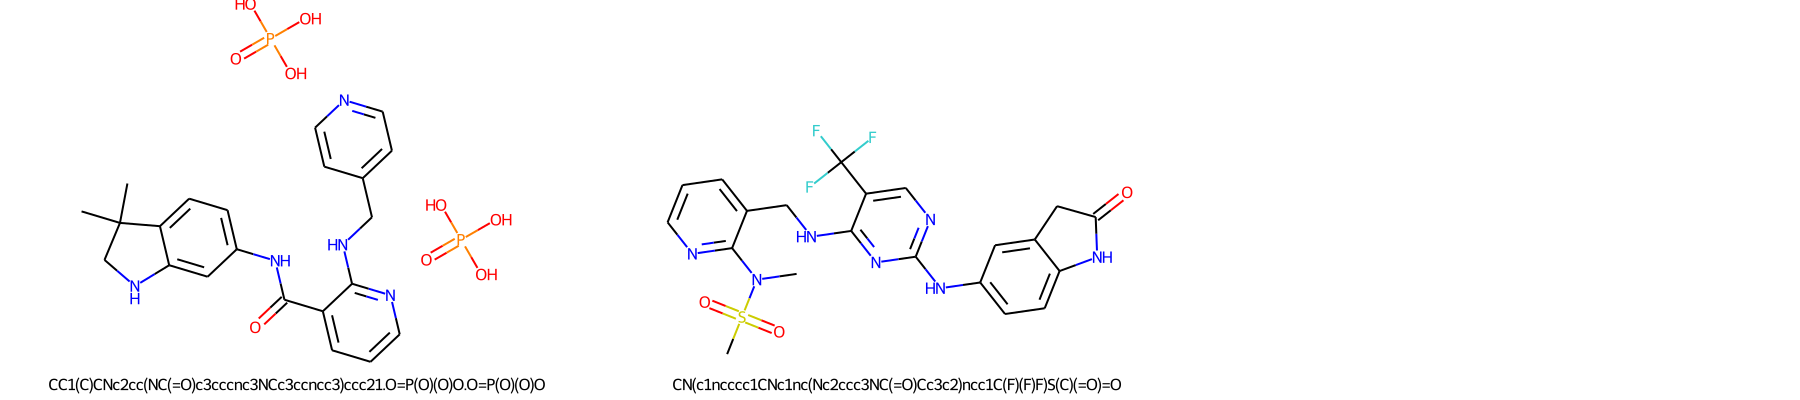

0.6816386969397829


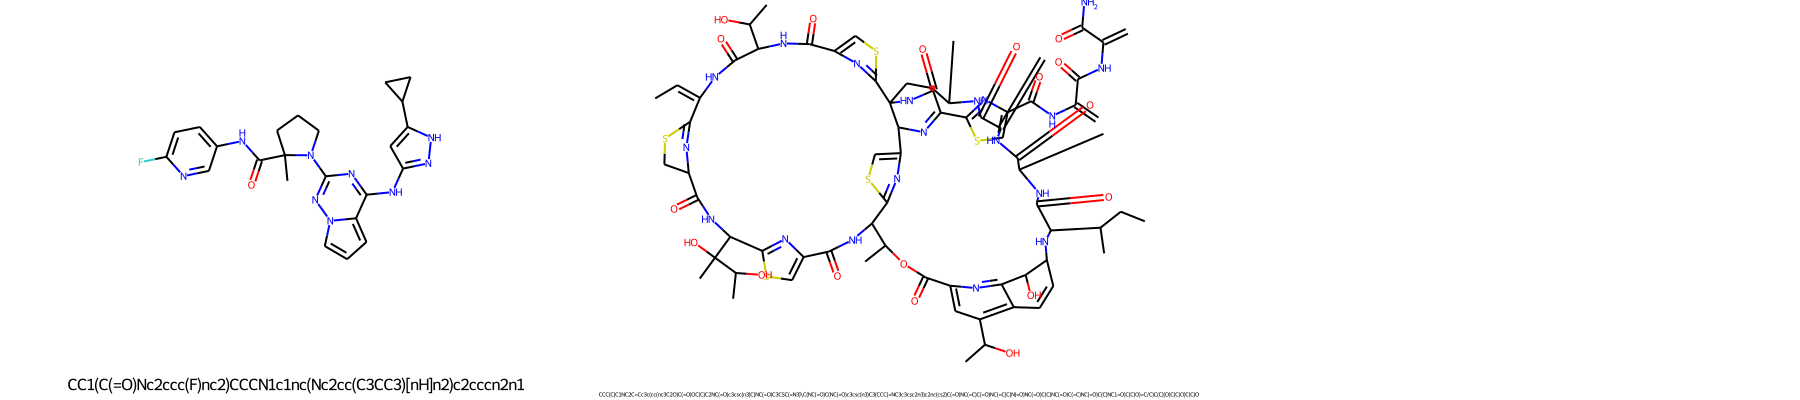

0.8193445243804957


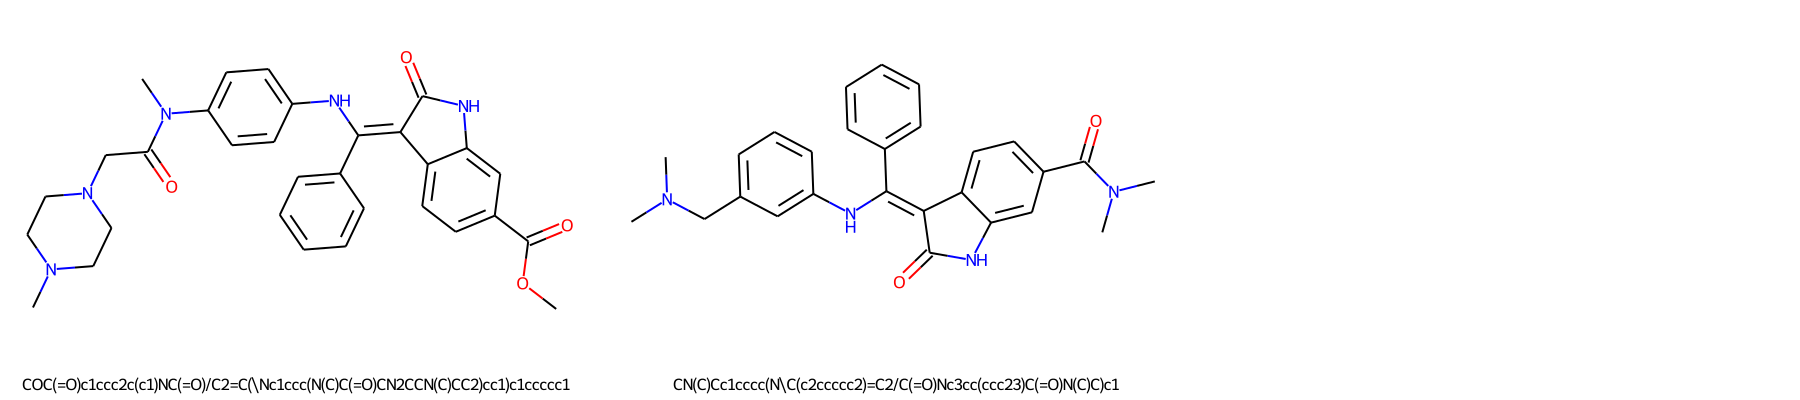

<Figure size 320x320 with 0 Axes>

In [118]:
for orig, lincs in zip(smiles_sciplex, smiles_lincs):
    im = Draw.MolsToGridImage([Chem.MolFromSmiles(orig), Chem.MolFromSmiles(lincs)], subImgSize=(600, 400),
                              legends=[orig, lincs]
                             )
    print(tanimoto_score(orig, lincs))
    plt.tight_layout()
    display(im)

## Create the ood split for `adata_lincs`

In [78]:
adata_lincs.obs['split_ood_drugs'][adata_lincs.obs.condition.isin(ood_drugs)]

['CS(=O)(=O)O.O=C(Nc1cccc(Cl)c1)Nc1ncc(CCNc2ncnc3ccsc23)s1',
 'COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\\Nc1ccc(N(C)C(=O)CN2CCN(C)CC2)cc1)c1ccccc1',
 'Cl.Cl.Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21',
 'CC(Oc1cc(-c2cnn(C3CCNCC3)c2)cnc1N)c1c(Cl)ccc(F)c1Cl',
 'CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1',
 'CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C(O)C1.Cl',
 'Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1',
 'CCN(c1cc(-c2ccc(CN3CCOCC3)cc2)cc(C(=O)NCc2c(C)cc(C)[nH]c2=O)c1C)C1CCOCC1',
 'CC1(C(=O)Nc2ccc(F)nc2)CCCN1c1nc(Nc2cc(C3CC3)[nH]n2)c2cccn2n1',
 'CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC',
 'CC(/C=C/C(=O)NO)=C\\[C@@H](C)C(=O)c1ccc(N(C)C)cc1',
 'CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21.O=P(O)(O)O.O=P(O)(O)O',
 'COc1cc2c(Oc3ccc4[nH]c(C)cc4c3F)ncnc2cc1OCCCN1CCCC1']

In [153]:
ood_conditions = adata_lincs.obs.condition[ood_idx].unique()

adata_lincs.obs.loc[adata_lincs.obs.condition.isin(ood_conditions), 'condition'].value_counts()[:len(ood_conditions)]

trichostatin-a    3692
alvocidib          886
crizotinib         845
GDC-0941           833
PF-562271          755
roscovitine        720
motesanib          707
brivanib           674
nintedanib         666
tubastatin-a       577
BIX-02189          543
azacitidine        439
BRD-K71726959      232
cediranib          192
JNJ-26481585       189
BMS-754807         172
vinorelbine        170
thiostrepton       159
vitexin             63
SNS-314             60
BRD-K05979026       45
BRD-K76021727       43
Name: condition, dtype: int64

In [156]:
adata_lincs.obs['split_ood_drugs'] = adata_lincs.obs['random_split']

adata_lincs.obs['split_ood_drugs'].value_counts()

train    714575
ood       63051
test      63051
Name: split_ood_drugs, dtype: int64

In [157]:
adata_lincs.obs.loc[adata_lincs.obs.condition.isin(ood_conditions), 'split_ood_drugs'] = 'ood'

adata_lincs.obs['split_ood_drugs'].value_counts()

train    703853
ood       74784
test      62040
Name: split_ood_drugs, dtype: int64

## Save `adata_lincs`

In [ ]:
fname_lincs = PROJECT_DIR/'datasets'/'lincs_complete.h5ad'

sc.write(fname_lincs, adata_lincs)